# An overview of *Cliqster*
### by Aaron Zolnai-Lucas

This notebook aims to cover the algorithm presented in [arXiv:1510.01374](https://arxiv.org/abs/1510.01374), for a reader with limited mathematical knowledge, along with a python implementation of the algorithm for experimentation.

1. [Mathematical Background](#maths) <br>
2. [The Cliqster Algorithm](#algorithm) <br>
3. [Tool for machine learning classification with Cliqster](#ml)

In [1]:
# requirements: python3, pip install numpy scipy pandas matplotlib networkx scikit-learn [--User]
import warnings
import itertools
import time
import random
import networkx as nx
import numpy as np
import pandas as pd
from scipy.optimize import minimize, LinearConstraint
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
np.set_printoptions(formatter={
    'float': lambda x: "{0:0.2f}".format(x).replace('0'," "),
    'int': lambda x: "{}".format(x).replace('0'," ")
})
def graph_draw(G, *a, **kw):
    fig = plt.figure()
    nx.draw(G, *a, **kw, with_labels=True, edge_color='white', node_color='skyblue')
    x = (len(G)**0.8); fig.set_size_inches(x,x); fig.set_facecolor("#252526")
    plt.show()

<a id="maths"></a>
## Graph Theory Background
Consider the following *connected, undirected graph* $G$:

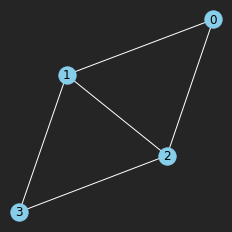

In [2]:
G = nx.Graph()
G.add_nodes_from([0,1,2,3])
G.add_edges_from([(0,1),(0,2),(1,2),(1,3),(2,3)])
graph_draw(G)

We can view the graph as a *adjacency matrix* $Y$, with node labels indicating column and row number (from here on in we freely interchange graphs with their adjacency matrices). Entries $(i, j)$ are $1$ if $(i, j)$ is an edge in $G$. Because the graph is undirected, the matrix is always symmetric about the diagonal, so we may take the lower triangular version without loss of generality

In [3]:
print(nx.to_numpy_array(G, dtype=int))

[[  1 1  ]
 [1   1 1]
 [1 1   1]
 [  1 1  ]]


We can find the *maximal cliques* in a graph using the Bron-Kerbosch algorithm, which runs in $O(n)$ time if the maximum degree of vertices in $G$ is bounded. *Cliques* are subsets of a graph $G$ which are fully connected. Maximal cliques are those to which no other vertices may be added whilst staying a clique. From this point, we take cliques to mean *maximal* cliques.

In [4]:
cliques = list(nx.find_cliques(G))
for cliq in cliques:
    print(set(cliq))

{0, 1, 2}
{1, 2, 3}


We can find the adjacency matrices in turn for each of these cliques with the following function and show the clique as its own graph to check:

In [5]:
def cliq_adj_mat(clique, n):
    return np.array(
        [[i!=j and i in clique and j in clique for j in range(n)] for i in range(n)], # i > j for lower triangular
        dtype=int)

In [6]:
clique_mat = cliq_adj_mat(cliques[0], 4)
print(clique_mat)

[[  1 1  ]
 [1   1  ]
 [1 1    ]
 [       ]]


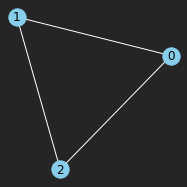

In [7]:
clique = nx.from_numpy_array(clique_mat)
clique_subgraph = nx.graphviews.subgraph_view(clique, filter_node=lambda v: len(clique[v]) > 0)
graph_draw(clique_subgraph)

## Graph Generation
Suppose that $G$ was generated by an underlying model, where for some symmetric $Z\in[0,1]^{n\times n}$
$$Y \sim \text{Bernoulli}(Z) \qquad \text{ie} \;P(Y_{ij}=1) = P(Y_{ji}=1) = Z_{ij} \;\text{and}\;P(Y_{ij}=0) = P(Y_{ji}=0) = 1-Z_{ij}$$
We call $Z$ the *generating matrix* of $G$. The above is equivalent to saying:
$$\textit{"There is a biased coin for each pair of vertices i and j which is flipped to decide whether i and j are neighbours or not"}$$
Cliqster takes the assumption that all networks are generated by such Bernoulli generating matrices, and that we can classify different types of network by these matrices.

For example (We may take $Z$ to be lower triangular since $G$ is undirected, without loss of generality):

In [8]:
n = 10
Z = np.tril(np.random.random([n,n]), k=-1) * 2/3
print(Z)

[[ .    .    .    .    .    .    .    .    .    .  ]
 [ . 2  .    .    .    .    .    .    .    .    .  ]
 [ .29  .27  .    .    .    .    .    .    .    .  ]
 [ .26  .33  .    .    .    .    .    .    .    .  ]
 [ .1   .47  .3   .22  .    .    .    .    .    .  ]
 [ .32  .16  .56  .61  .13  .    .    .    .    .  ]
 [ .11  .27  .3   .5   .6   .57  .    .    .    .  ]
 [ .59  .59  .6   .25  . 6  . 6  .51  .    .    .  ]
 [ .32  .26  .19  .62  .18  .37  .39  .6   .    .  ]
 [ .31  . 4  .15  .22  .14  .17  .35  .64  .45  .  ]]


In [9]:
def sample_graph(Z, ensure_connected=True, show=False):
    sampledZ = np.random.binomial(1, Z)
    A = sampledZ + np.transpose(sampledZ)
    G = nx.from_numpy_array(A)
    if ensure_connected and not nx.is_connected(G):
        return sample_graph(Z, ensure_connected=True, show=show)
    else:
        if show:
            print(A, '\n\n')
            graph_draw(G)
        return G

[[    1         1    ]
 [    1   1     1    ]
 [1 1       1 1      ]
 [          1 1      ]
 [  1         1   1  ]
 [    1 1            ]
 [    1 1 1       1  ]
 [1 1             1 1]
 [        1   1 1   1]
 [              1 1  ]] 




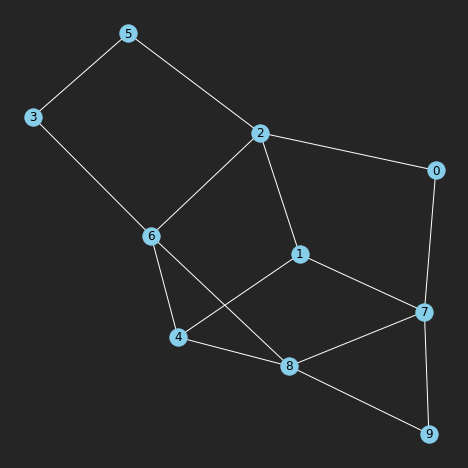

In [10]:
G = sample_graph(Z, show=True)

<a id="algorithm"></a>
## Cliqster
In linear algebra, the *Singular Value Decomposition (SVD)* for matrices is a useful way to represent a matrix (which all represent linear transformations on $n$ dimensions). It (loosely) decomposes a linear transformation into a sum of scale factors $\mu_k$ multiplied by rotation transformations $B_k$. It gives us the directions in which the transformation acts most strongly, amongst other things.

Since the generating matrix $Z$ of a graph $G$ is not derived from a linear transformation, its SVD gives us little information about our original graph, but it is natural to ask whether a decomposition exists that *does* tell us something interesting about the graph structure.

In cliqster, we decompose $Z$ into a sum of scale factors $\mu_k > 0$ multiplied by adjacency matrices of cliques of $G$, $B_k$. We then hope to classify ($Z$ and by extension $G$) by taking a certain number of top $\mu_k$ values. We wish to express $Z$ as:

$$ Z = \sum\limits_k\mu_kB_k. $$

However, given a network $G$ and no prior information about its generating matrix $Z$, we are forced to take a maximum likelihood estimate for $Z$ in order to find the $\mu$ values. It is trivial to see that the most likely model to have generated $G$ is in fact its own adjacency matrix, $Y$, so take $Z = Y$:

$$ Y = \sum\limits_k\mu_kB_k. $$

$$\text{Let}\qquad b^{ij} := \left(\{B_1\}_{ij},\{B_2\}_{ij},\dots,\{B_K\}_{ij}\right)^\intercal \qquad \mu := \left(\mu_1,\mu_2,\dots,\mu_K\right)^\intercal$$

$$y := \left(Y_{21}, Y_{31}, Y_{32}, \dots, Y_{n(n-1)}\right)^\intercal \qquad \mathcal{B} := \left(b^{21}, b^{31}, b^{32}, \dots, b^{n(n-1)}\right)^\intercal.$$

$$\text{Then}\qquad y = \mathcal{B}\mu.$$

where $y$ is a $1\times {n\choose 2}$ vector and $\mathcal{B}$ is a $K\times {n\choose 2}$ matrix. This is a matrix equation with $K$ unknowns in $\mu$ and ${n \choose 2}$ constraints. This may have infinite solutions, but, more unfortunately, it may also have no solutions. To see this, consider the graph $G$ we first showed in this notebook. $G$ had adjacency matrix

$$\begin{bmatrix} 0 & 1 & 1 & 0 \\ 1 & 0 & 1 & 1 \\ 1 & 1 & 0 & 1 \\ 0 & 1 & 1 & 0 \end{bmatrix}$$

and maximal cliques $\{0,1,2\}$ and $\{1,2,3\}$, but it's clear no factors $\mu_1, \mu_2 > 0$ of their adjacency matrices

$$ B_1 := \begin{bmatrix} 0 & 1 & 1 & 0 \\ 1 & 0 & 1 & 0 \\ 1 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 \end{bmatrix} \qquad \text{and} \qquad B_2:=\begin{bmatrix} 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 1 \\ 0 & 1 & 0 & 1 \\ 0 & 1 & 1 & 0 \end{bmatrix}$$

gives us $H$ back since the top row of $G$ must be given by $B_1$, implying $\mu_1 = 1$ and similarly, the bottom row of $G$ must be given by $B_2$, implying that $\mu_2 = 1$. But this is a conradiction on the middle rows, i.e:

$$ \left(\mu_1B_1 + \mu_2B_2\right)_{12} = 1 + 1 = 2 \neq 1 = G_{12}.$$

Thus, given a perfect solution may not be available, we go for the next best thing, namely to solve the corresponding least squares problem. Given we are classifying networks based on their generating matrix, we had better also add the constraint that $0\leq b^{ij}\cdot\mu\leq 1$, since this corresponds to ensuring that the probabilities in $Z$ are between $0$ and $1$. Thus the problem is:

$$\text{minimize}\quad ||\mathcal{B}\mu - y||_2^2 = \sum\limits_i\sum\limits_j({b^{ij}}\cdot\mu - Y_{ij})^2 = \sum\limits_{i>j}({b^{ij}}\cdot\mu - Y_{ij})^2 \quad \text{subject to} \quad 0\leq b^{ij}\cdot\mu\leq 1$$

In [11]:
def cliqster(G:nx.Graph, topXmu, verbose:bool=False):
    """
    Gives the ordered cliques and mu values for a graph G, along with the reconstructed generator of G, Z.

    Note: we solve the least-squares with a scipy method which does not exploit linearity, since it was the only way to add
    linear constraints I could find. Thus this could be sped up, eg. see python module cvxpy. I wanted to keep to well-known
    libraries for this notebook to make it more user-friendly.
    """
    Y = np.tril(nx.to_numpy_array(G, dtype=int))
    cliques = [set(cliq) for cliq in nx.find_cliques(G)]
    n, K = len(G), len(cliques)
    Bk = [np.tril(cliq_adj_mat(cliq, n)) for cliq in cliques]

    B, y = [], []
    for i in range(n):
        for j in range(i): # so (i > j):
            B.append([b[i][j] for b in Bk])
            y.append(Y[i][j])

    B = np.array(B)
    y = np.array(y)

    lsq = lambda mu: np.sum((B @ mu - y)**2)
    mu_constraint = LinearConstraint(B, 0, 1)

    # solve linear-constraint-linear-least-squares
    mu = minimize(lsq, x0=np.zeros(K), method='trust-constr', constraints=[mu_constraint]).x
    
    topmu = np.sort(mu)[:-topXmu-1:-1]
    topmu = [x for x,_ in itertools.zip_longest(topmu, range(topXmu), fillvalue=0)]

    if verbose:
        # construct the generating Z (not necessary but informative)
        Z = np.sum(mu_k * b for mu_k, b in zip(mu, Bk))
        # make dataframe of results
        clique_rankings = pd.DataFrame({
            'clique': [str(c) for c in cliques],
            'mu_k': mu
        }).sort_values('mu_k', ascending=False)
        return clique_rankings, Z, topmu
    return topmu

In [12]:
clique_rankings, Z, topmu = cliqster(G, topXmu=len(G), verbose=True)
clique_rankings

,clique,mu_k
2,"{2, 5}",0.998117
4,"{3, 5}",0.998117
8,"{0, 7}",0.998117
9,"{1, 7}",0.998117
7,"{1, 4}",0.998117
0,"{0, 2}",0.998117
3,"{2, 6}",0.998117
1,"{1, 2}",0.998117
5,"{3, 6}",0.998117
6,"{8, 4, 6}",0.998116


In [13]:
print("Constructed generator Z:", Z, sep='\n'); print("Top mu vals:", np.array(topmu), sep='\n')

Constructed generator Z:
[[ .    .    .    .    .    .    .    .    .    .  ]
 [ .    .    .    .    .    .    .    .    .    .  ]
 [1.   1.    .    .    .    .    .    .    .    .  ]
 [ .    .    .    .    .    .    .    .    .    .  ]
 [ .   1.    .    .    .    .    .    .    .    .  ]
 [ .    .   1.   1.    .    .    .    .    .    .  ]
 [ .    .   1.   1.   1.    .    .    .    .    .  ]
 [1.   1.    .    .    .    .    .    .    .    .  ]
 [ .    .    .    .   1.    .   1.   1.    .    .  ]
 [ .    .    .    .    .    .    .   1.   1.    .  ]]
Top mu vals:
[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.  ]


The authors then continue to motivate this method by showing that the unconstrained version of this least-squares problem has an intrinsic relationship to the initial graph $G$ (unlike SVD). Namely, by differentiating $J$ to find its minimum (since it is convex on $\mu$), we find a relationship:

$$ A\mu = d $$

where A is a $K\times K$ matrix that counts shared edges between the indexed maximal cliques, and $d$ is a $1\times K$ vector that measures how "overlapping" a particular clique is to each other clique in the network for each index. In this solution, the probabilities in the generating $Z$ could be $<0$ or $>1$.

We can only speculate that the authors did not find a good way of using the $\mu$ values from this problem for classification or deriving a meaningful $Z$ from, as this method is both more natural, constructive, and more efficient (simple matrix inversion) than the constrained equivalent.

The authors go on to present encouraging results for the classification of suspicious individuals using cliqster, by training a k-Nearest Neighbours algorithm on a large dataset, and besting both SVD and Graphlet decomposition. A significant question mark is how to extend the method for groups of mixed individuals, though, unlike the test data in the paper.

We give the unconstrained version of the algorithm for completeness. In the situation where a 'perfect' solution exists, this will match the constrained version.

In [14]:
def cliqster_unconstrained(G, topXmu, verbose=False):
    Y = np.tril(nx.to_numpy_array(G, dtype=int))
    cliques = [set(cliq) for cliq in nx.find_cliques(G)]
    n, K = len(G), len(cliques)
    Bk = [np.tril(cliq_adj_mat(cliq, n)) for cliq in cliques]

    A = np.zeros((K,K), dtype=np.int64)
    d = np.zeros(K, dtype=np.int64)

    for i in range(n):
        for j in range(i): # so (i > j):
            b_ij = np.array([b[i][j] for b in Bk], dtype=int)
            A += np.outer(b_ij, np.transpose(b_ij))
            d += Y[i][j] * b_ij

    # solve linear-least-squares
    mu = np.linalg.solve(A, d)
    
    topmu = np.sort(mu)[:-topXmu-1:-1]
    topmu = [x for x,_ in itertools.zip_longest(topmu, range(topXmu), fillvalue=0)]

    if verbose:
        # construct the generating Z (not necessary but informative)
        Z = np.sum(mu_k * b for mu_k, b in zip(mu, Bk))
        # make dataframe of results
        clique_rankings = pd.DataFrame({
            'clique': [str(c) for c in cliques],
            'mu_k': mu
        }).sort_values('mu_k', ascending=False)
        return clique_rankings, Z, topmu
    return topmu

In [15]:
unconstr_clique_rankings, unconstr_Z, unconstr_topmu = cliqster_unconstrained(G, topXmu=len(G), verbose=True)
unconstr_clique_rankings

,clique,mu_k
0,"{0, 2}",1.0
1,"{1, 2}",1.0
2,"{2, 5}",1.0
3,"{2, 6}",1.0
4,"{3, 5}",1.0
5,"{3, 6}",1.0
6,"{8, 4, 6}",1.0
7,"{1, 4}",1.0
8,"{0, 7}",1.0
9,"{1, 7}",1.0


In [16]:
print("Constructed Generator Z", unconstr_Z, sep='\n'); print("Top mu values", unconstr_topmu, sep='\n')

Constructed Generator Z
[[ .    .    .    .    .    .    .    .    .    .  ]
 [ .    .    .    .    .    .    .    .    .    .  ]
 [1.   1.    .    .    .    .    .    .    .    .  ]
 [ .    .    .    .    .    .    .    .    .    .  ]
 [ .   1.    .    .    .    .    .    .    .    .  ]
 [ .    .   1.   1.    .    .    .    .    .    .  ]
 [ .    .   1.   1.   1.    .    .    .    .    .  ]
 [1.   1.    .    .    .    .    .    .    .    .  ]
 [ .    .    .    .   1.    .   1.   1.    .    .  ]
 [ .    .    .    .    .    .    .   1.   1.    .  ]]
Top mu values
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


<a id="ml"></a>
## *Classification testing using Cliqster and k-NN*
*We generate 2 groups of networks from 2 generating matrices as defined above. We then try and classify them using the k-Nearest Neighbours algorithm. The following is meant to be a tool for testing the sensitivity of cliqster to various parameters.*

In [17]:
""" Parameters for classification test"""
n = 7                          # The number of vertices in all the networks
n_train, n_test = 100, 20      # The sizes of our training and testing sets
Z1factor, Z2factor = 4/5, 2/5  # Factor by which Z1, Z2 are multiplied.
use_random_Z = False           # Pick elements of Z from unif. random dist. if True or just 1s if False
topXmu = 8                     # #top mu values we take from cliqster as features to classify networks
num_neighbors = 13             # number of nearest neighbors to aggregate in k-NN classification

In [18]:
zgen = np.random.random([n,n]) if use_random_Z else np.ones([n,n])
Z1 = np.tril(zgen, k=-1) * Z1factor
Z2 = np.tril(zgen, k=-1) * Z2factor
print(f"Z1\n{Z1}\n\nZ2\n{Z2}")

Z1
[[ .    .    .    .    .    .    .  ]
 [ .8   .    .    .    .    .    .  ]
 [ .8   .8   .    .    .    .    .  ]
 [ .8   .8   .8   .    .    .    .  ]
 [ .8   .8   .8   .8   .    .    .  ]
 [ .8   .8   .8   .8   .8   .    .  ]
 [ .8   .8   .8   .8   .8   .8   .  ]]

Z2
[[ .    .    .    .    .    .    .  ]
 [ .4   .    .    .    .    .    .  ]
 [ .4   .4   .    .    .    .    .  ]
 [ .4   .4   .4   .    .    .    .  ]
 [ .4   .4   .4   .4   .    .    .  ]
 [ .4   .4   .4   .4   .4   .    .  ]
 [ .4   .4   .4   .4   .4   .4   .  ]]


In [19]:
# generate train/test data
t0 = time.perf_counter()
train_graphs = [sample_graph(Z1) for _ in range(n_train//2)] + [sample_graph(Z2) for _ in range(n_train//2)]
train_labels = [1 for _ in range(n_train//2)] + [2 for _ in range(n_train//2)]
test_graphs = [sample_graph(Z1) for _ in range(n_test//2)] + [sample_graph(Z2) for _ in range(n_test//2)]
test_labels = [1 for _ in range(n_test//2)] + [2 for _ in range(n_test//2)]
t1 = time.perf_counter()
print("train, test sets generated in {0:0.2f}s".format(t1-t0))

train, test sets generated in 0.02s


In [20]:
# get top mu vals, this step will take longest.
t2 = time.perf_counter()
train = [cliqster(G, topXmu=topXmu) for G in train_graphs]
test = [cliqster(G, topXmu=topXmu) for G in test_graphs]
t3 = time.perf_counter()
print("cliqster transforms done in {0:0.2f}s".format(t3-t2))

cliqster transforms done in 7.08s


In [21]:
# train k-NN and predict labels. As a side note, kNN is not sensitive to shuffling.
t4 = time.perf_counter()
k3nn = KNeighborsClassifier(n_neighbors=num_neighbors)
k3nn.fit(train, train_labels)
predicted_labels = k3nn.predict(test)
t5 = time.perf_counter()
print("k-NN training and testing done in {0:0.2f}s".format(t5-t4))

k-NN training and testing done in 0.00s


In [22]:
# display results
correct = sum([t==p for t,p in zip(test_labels, predicted_labels)])
print("Finished k-NN classification with Cliqster,")
print(f"with parameters: num_vertices: {n}, train_graphs: {n_train}, test_graphs: {n_test},  top_X_mu_vals: {topXmu}, k-neighbors: {num_neighbors}, Z1_factor: {Z1factor}, Z2_factor: {Z2factor}, use_random_Z: {use_random_Z}")
print("Accuracy: {0} / {1} ({2:0.1f}%)".format(correct, n_test, 100*correct/n_test))

Finished k-NN classification with Cliqster,
with parameters: num_vertices: 7, train_graphs: 100, test_graphs: 20,  top_X_mu_vals: 8, k-neighbors: 13, Z1_factor: 0.8, Z2_factor: 0.4, use_random_Z: False
Accuracy: 20 / 20 (100.0%)


Lastly, we can make a plot of the mean top $\mu$ values for $Z_1$ and $Z_2$ from the training set to see how separable they were.

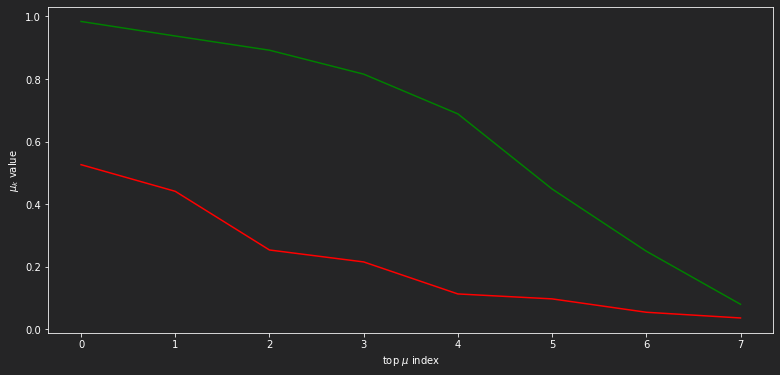

In [23]:
mean_mu_Z1 = np.mean(train[:n_train//2], axis=0)
mean_mu_Z2 = np.mean(train[n_train//2:], axis=0)

fig = plt.figure(); ax = plt.gca()
plt.plot(mean_mu_Z1, 'r')
plt.plot(mean_mu_Z2, 'g')
fig.set_facecolor("#252526"); ax.set_facecolor("#252526")
fig.set_size_inches(13,6)
plt.xlabel('top $\mu$ index'); plt.ylabel('$\mu_k$ value')
plt.show()